# 4. Сверточные нейронные сети.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г.

In [1]:
import typing as t
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("data/")
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR = Path("models/")
MODELS_DIR.mkdir(exist_ok=True)
COLAB_DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/ML")

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cpu device


In [6]:
# полезные полезности из этой и предыдущей частей

def is_colab() -> bool:
    return DEVICE == "cuda"


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: DataLoader,
        epochs: int,
        verbose: int = 100,
        test_dataloader: DataLoader = None,
) -> t.List[float]:
    train_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, verbose)
        train_losses.append(train_loss.item())
        if test_dataloader:
            test_loop(test_dataloader, model, loss_fn)
    return train_losses


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

    return avg_loss / num_batches


def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy


class FastDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset

        n = len(self.dataset)
        x, _ = self.dataset[0]
        self._data = torch.empty(n, *x.size(), dtype=x.dtype)
        self._targets = [0] * n
        for i, (x, y) in tqdm(enumerate(self.dataset), total=n):
            self._data[i] = x
            self._targets[i] = y

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self._data[idx], self._targets[idx]


def plot_losses(losses):
    plt.plot(torch.arange(len(losses)), losses)


def _color_imshow(img):
    plt.imshow(torch.clip(img.permute(1, 2, 0), 0, 1))


def _gray_imshow(img):
    plt.imshow(img.squeeze(), cmap="gray")


def visualize_predicts(
        model: nn.Module,
        dataset: Dataset,
        classes,
        cols: int = 4,
        rows: int = 4,
        figsize=(10, 11),
        imshow=_color_imshow,
):
    model.eval()

    fig = plt.figure(figsize=figsize)
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()  # noqa
        img, true_label = dataset[sample_idx]

        pred = model(img.unsqueeze(0).to(DEVICE))
        pred_proba = F.softmax(pred, 1).max(1).values.item()
        pred_label = pred.argmax(1).item()

        fig.add_subplot(rows, cols, i)
        plt.title(
            f"pred: {classes[pred_label]} ({pred_proba:.2f})"
            f"\ntrue: {classes[true_label]}", loc="left"
        )
        plt.axis("off")
        imshow(img.cpu())


def plot_confusion_matrix(y_true, y_pred, classes):
    cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=classes,
        xticks_rotation=45,
        cmap=sns.color_palette("light:b", as_cmap=True),
        colorbar=False,
    )
    cm_display.ax_.grid(False)
    cm_display.figure_.set_size_inches(4.5, 4.5)


def get_y_test_y_pred_batches(model: nn.Module, test_dataloader: DataLoader):
    model.eval()

    y_test = []
    y_pred = []
    for x, y in test_dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x).argmax(1)
        y_test.append(y)
        y_pred.append(pred)

    return torch.hstack(y_test).detach().cpu(), torch.hstack(y_pred).detach().cpu()

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [7]:
if is_colab():
    from google.colab import drive

    drive.mount('/content/drive')
    !cp -r "/content/drive/MyDrive/Colab Notebooks/ML/monkeys" "/content/data/"

Mounted at /content/drive


In [8]:
transform = transforms.Compose([
    transforms.Resize(size=(96, 96)),  # меньше размер - быстрее
    transforms.ToTensor(),
    # случайная аугментация сильно замедлит обучение
])

train_monkeys_dataset = datasets.ImageFolder(
    DATA_DIR / "monkeys/training/training",
    transform=transform,
)
test_monkeys_dataset = datasets.ImageFolder(
    DATA_DIR / "monkeys/validation/validation",
    transform=transform,
)

(
    (len(train_monkeys_dataset), len(test_monkeys_dataset)),
    train_monkeys_dataset[0][0].shape,
    len(train_monkeys_dataset.classes),
)

((1097, 272), torch.Size([3, 96, 96]), 10)

Архитектура модели "Ничего не изменилось" (от автора "А что если попробовать то же самое?" и "Зачем что-то менять?")

In [9]:
class MonkeysConvNet(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(MonkeysConvNet, self).__init__()
        # переменные для простого управления границей светрка-классификатор
        out_channels = 64
        width, height = 6, 6

        self.features = nn.Sequential(OrderedDict({
            "conv1": nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            "norm1": nn.BatchNorm2d(32),
            "relu1": nn.ReLU(True),
            "maxpool1": nn.MaxPool2d(2),
            "conv2": nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=3, stride=1),
            "norm2": nn.BatchNorm2d(out_channels),
            "relu2": nn.ReLU(True),
            "maxpool2": nn.MaxPool2d(2),
        }))
        self.avgpool = nn.AdaptiveAvgPool2d((width, height))
        self.classifier = nn.Sequential(OrderedDict({
            "fc1": nn.Linear(out_channels * width * height, 1024),
            "relu1": nn.ReLU(True),
            "drop1": nn.Dropout(),
            "fc2": nn.Linear(1024, 512),
            "relu2": nn.ReLU(True),
            "drop2": nn.Dropout(),
            "fc3": nn.Linear(512, 128),
            "relu3": nn.ReLU(True),
            "drop3": nn.Dropout(),
            "fc4": nn.Linear(128, n_classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
fast_train_monkeys_dataset = FastDataset(train_monkeys_dataset)
fast_test_monkeys_dataset = FastDataset(test_monkeys_dataset)

100%|██████████| 1097/1097 [00:30<00:00, 36.49it/s]


In [11]:
torch.manual_seed(0)

net = MonkeysConvNet(3, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

monkeys_train_dataloader = DataLoader(
    fast_train_monkeys_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2 if is_colab() else 0,
)
monkeys_test_dataloader = DataLoader(
    fast_test_monkeys_dataset,
    batch_size=600,  # если все картинки не помещаются в память
    num_workers=2 if is_colab() else 0,
)

net

MonkeysConvNet(
  (features): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=2304, out_features=1024, bias=True)
    (relu1): ReLU(inplace=True)
    (drop1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=1024, out_features=512, bias=True)
    (relu2): ReLU(inplace=True)
    (drop2): Dropout(p=0.5, inplace=False)
    (fc3): Linear(in_

In [12]:
%%time

train_losses = common_train(
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=monkeys_train_dataloader,
    epochs=30,
    verbose=50,
    test_dataloader=monkeys_test_dataloader,
)

Epoch 1
--------------------------------
loss: 2.356887  [    0/ 1097]
loss: 2.728583  [  400/ 1097]
loss: 2.240510  [  800/ 1097]
Test Error: 
 Accuracy: 0.216912, Avg loss: 2.147304 

Epoch 2
--------------------------------
loss: 2.302687  [    0/ 1097]
loss: 2.373704  [  400/ 1097]
loss: 1.972593  [  800/ 1097]
Test Error: 
 Accuracy: 0.294118, Avg loss: 1.904010 

Epoch 3
--------------------------------
loss: 1.738032  [    0/ 1097]
loss: 1.936925  [  400/ 1097]
loss: 1.934522  [  800/ 1097]
Test Error: 
 Accuracy: 0.371324, Avg loss: 1.689137 

Epoch 4
--------------------------------
loss: 1.739639  [    0/ 1097]
loss: 2.296619  [  400/ 1097]
loss: 1.515404  [  800/ 1097]
Test Error: 
 Accuracy: 0.408088, Avg loss: 1.610640 

Epoch 5
--------------------------------
loss: 2.043075  [    0/ 1097]
loss: 1.813443  [  400/ 1097]
loss: 1.122600  [  800/ 1097]
Test Error: 
 Accuracy: 0.393382, Avg loss: 1.674352 

Epoch 6
--------------------------------
loss: 1.776257  [    0/ 1097]

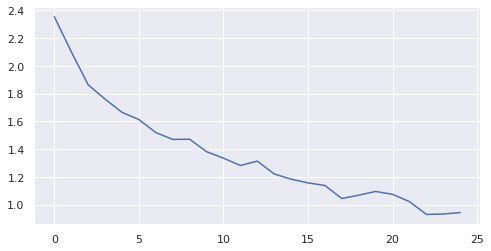

In [13]:
plot_losses(train_losses);

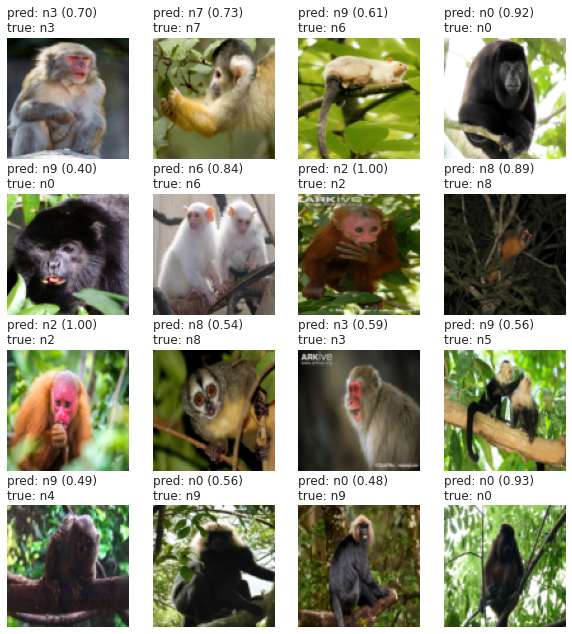

In [14]:
torch.manual_seed(0)

visualize_predicts(
    model=net,
    dataset=test_monkeys_dataset,
    classes=test_monkeys_dataset.classes,
)

In [ ]:
y_test, y_pred = get_y_test_y_pred_batches(
    model=net,
    test_dataloader=monkeys_test_dataloader,
)

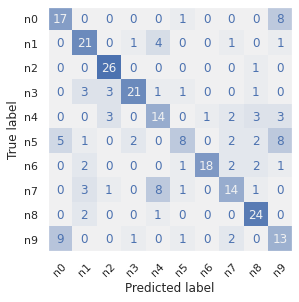

In [15]:
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    classes=test_monkeys_dataset.classes,
);

In [16]:
print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=test_monkeys_dataset.classes,
))

              precision    recall  f1-score   support

          n0       0.55      0.65      0.60        26
          n1       0.66      0.75      0.70        28
          n2       0.79      0.96      0.87        27
          n3       0.84      0.70      0.76        30
          n4       0.50      0.54      0.52        26
          n5       0.62      0.29      0.39        28
          n6       0.95      0.69      0.80        26
          n7       0.61      0.50      0.55        28
          n8       0.71      0.89      0.79        27
          n9       0.38      0.50      0.43        26

    accuracy                           0.65       272
   macro avg       0.66      0.65      0.64       272
weighted avg       0.66      0.65      0.64       272



In [17]:
torch.save(net, MODELS_DIR / "Monkeys-cnn.pth")

In [18]:
# попытка освободить место на GPU (неуспешная)
if is_colab():
    torch.cuda.empty_cache()

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [24]:
if is_colab():
    from google.colab import drive

    drive.mount('/content/drive')
    !cp -r "/content/drive/MyDrive/Colab Notebooks/ML/cats_dogs" "/content/data/"

In [25]:
transform = transforms.Compose([
    transforms.Resize(size=(96, 96)),
    transforms.ToTensor(),
])

cats_dogs_dataset = datasets.ImageFolder(
    DATA_DIR / "cats_dogs/cats_dogs/train",
    transform=transform,
)

train_size = round(0.8 * len(cats_dogs_dataset))
train_cats_dogs_dataset, test_cats_dogs_dataset = random_split(
    cats_dogs_dataset,
    lengths=(train_size, len(cats_dogs_dataset) - train_size),
)

(
    (len(train_cats_dogs_dataset), len(test_cats_dogs_dataset)),
    train_cats_dogs_dataset[0][0].shape,
    len(cats_dogs_dataset.classes),
)

((20000, 5000), torch.Size([3, 96, 96]), 2)

Архитектура модели "Ничего не изменилось 2.0" (от автора культовых бестселлеров "А что если попробовать то же самое?", "Зачем что-то менять?", "Ничего не изменилось")

In [26]:
class CatsDogsConvNet(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(CatsDogsConvNet, self).__init__()
        out_channels = 64
        width, height = 6, 6
        self.features = nn.Sequential(OrderedDict({
            "conv1": nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            "norm1": nn.BatchNorm2d(32),
            "relu1": nn.ReLU(True),
            "maxpool1": nn.MaxPool2d(2),
            "conv2": nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=3, stride=1),
            "norm2": nn.BatchNorm2d(out_channels),
            "relu2": nn.ReLU(True),
            "maxpool2": nn.MaxPool2d(2),
        }))
        self.avgpool = nn.AdaptiveAvgPool2d((width, height))
        self.classifier = nn.Sequential(OrderedDict({
            "fc1": nn.Linear(out_channels * width * height, 1024),
            "relu1": nn.ReLU(True),
            "drop1": nn.Dropout(),
            "fc2": nn.Linear(1024, 512),
            "relu2": nn.ReLU(True),
            "drop2": nn.Dropout(),
            "fc3": nn.Linear(512, 128),
            "relu3": nn.ReLU(True),
            "drop3": nn.Dropout(),
            "fc4": nn.Linear(128, n_classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [27]:
fast_train_cats_dogs_dataset = FastDataset(train_cats_dogs_dataset)
fast_test_cats_dogs_dataset = FastDataset(test_cats_dogs_dataset)

100%|██████████| 5000/5000 [00:07<00:00, 657.27it/s]


In [35]:
torch.manual_seed(0)

net = CatsDogsConvNet(3, 2).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

cats_dogs_train_dataloader = DataLoader(
    fast_train_cats_dogs_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2 if is_colab() else 0,
)
cats_dogs_test_dataloader = DataLoader(
    fast_test_cats_dogs_dataset,
    batch_size=1024,
    num_workers=2 if is_colab() else 0,
)

net

CatsDogsConvNet(
  (features): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=2304, out_features=1024, bias=True)
    (relu1): ReLU(inplace=True)
    (drop1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=1024, out_features=512, bias=True)
    (relu2): ReLU(inplace=True)
    (drop2): Dropout(p=0.5, inplace=False)
    (fc3): Linear(in

In [32]:
%%time

train_losses = common_train(
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=cats_dogs_train_dataloader,
    epochs=20,
    verbose=100,
    test_dataloader=cats_dogs_test_dataloader,
)

Epoch 1
--------------------------------
loss: 0.791480  [    0/20000]
loss: 0.611108  [  640/20000]
loss: 0.631888  [ 1280/20000]
loss: 0.685873  [ 1920/20000]
loss: 0.578515  [ 2560/20000]
loss: 0.681476  [ 3200/20000]
loss: 0.673629  [ 3840/20000]
loss: 0.601334  [ 4480/20000]
loss: 0.577517  [ 5120/20000]
loss: 0.605565  [ 5760/20000]
loss: 0.611136  [ 6400/20000]
loss: 0.675287  [ 7040/20000]
loss: 0.626305  [ 7680/20000]
loss: 0.482350  [ 8320/20000]
loss: 0.556456  [ 8960/20000]
loss: 0.647784  [ 9600/20000]
loss: 0.569459  [10240/20000]
loss: 0.551912  [10880/20000]
loss: 0.597774  [11520/20000]
loss: 0.509041  [12160/20000]
loss: 0.524897  [12800/20000]
loss: 0.663040  [13440/20000]
loss: 0.647617  [14080/20000]
loss: 0.510952  [14720/20000]
loss: 0.511358  [15360/20000]
loss: 0.719283  [16000/20000]
loss: 0.484676  [16640/20000]
loss: 0.523789  [17280/20000]
loss: 0.473500  [17920/20000]
loss: 0.493399  [18560/20000]
loss: 0.578284  [19200/20000]
loss: 0.542391  [19840/20000]

KeyboardInterrupt: 

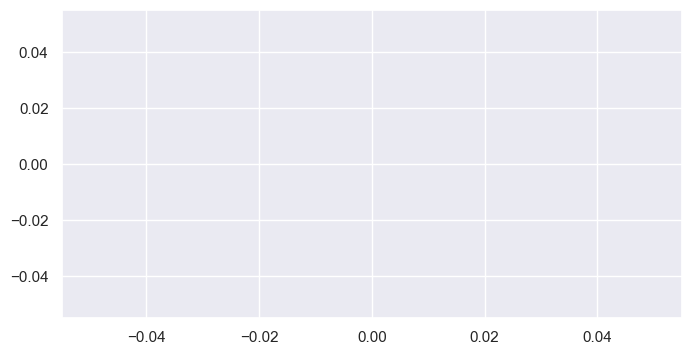

In [30]:
plot_losses(train_losses);

In [ ]:
torch.manual_seed(0)

visualize_predicts(
    model=net,
    dataset=test_cats_dogs_dataset,
    classes=cats_dogs_dataset.classes,
)

In [ ]:
y_test, y_pred = get_y_test_y_pred_batches(
    model=net,
    test_dataloader=cats_dogs_test_dataloader,
)

In [ ]:
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    classes=cats_dogs_dataset.classes,
);

In [ ]:
print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=cats_dogs_dataset.classes,
))

In [ ]:
torch.save(net, MODELS_DIR / "Cats-Dogs-cnn.pth")

In [ ]:
if is_colab():
    !zip -r "/content/models.zip" "/content/models"
    from google.colab import files

    files.download("/content/models.zip")